In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir("..")

In [4]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif
from deepsvg.svglib.geom import Bbox
from deepsvg.svgtensor_dataset import SVGTensorDataset, load_dataset
from deepsvg.utils.utils import batchify, linear

import torch
import numpy as np

# DeepSVG latent space operations

In [5]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

Load the pretrained model and dataset

In [6]:
pretrained_path = "./pretrained/hierarchical_ordered.pth.tar"
from configs.deepsvg.hierarchical_ordered import Config

try:
    state_dict = torch.load(pretrained_path, map_location=torch.device('cpu'))  # Use 'cuda' if you have GPU
    print("File loaded successfully.")
    print(state_dict.keys())  # Prints the keys to verify the content
except Exception as e:
    print(f"Error loading the file: {e}")

cfg = Config()
model = cfg.make_model().to(device)
utils.load_model(pretrained_path, model)
model.eval();

File loaded successfully.
dict_keys(['model'])


In [7]:
dataset = load_dataset(cfg)
cfg.data_dir

'./dataset/icons_tensor/'

In [8]:
def load_svg(filename):
    svg = SVG.load_svg(filename)
    svg.canonicalize()
    svg.normalize()
    svg.zoom(0.9)
    svg = svg.simplify_heuristic()
    svg =svg.numericalize(256)
    return svg

In [9]:
def encode(data):
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
        return z

def encode1(data, model, cfg):
     device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

     model_args = batchify((data[key] for key in cfg.model_args), device)
     with torch.no_grad():
         z = model(*model_args, encode_mode=True)
         return z.squeeze(dim=0).squeeze(dim=0)

    
def encode_svg(svg):
    data = dataset.get(svg=svg)
    return encode(data)


In [10]:
# Define paths
data_dir = "./dataset/Registered_Dataset_simplified/"
target_logo_path = "dataset/Query_Dataset_simplified/303120_facebook-messenger-white-logo.svg"
png_output_dir = "./dataset/rendered_pngs/"  # Directory to store PNGs

In [11]:
svg1= load_svg(target_logo_path)
target_vector =encode_svg(svg1)
target_vector

tensor([[[[-1.0682,  0.1912, -0.2318,  0.1597, -0.9057,  0.1175, -0.0365,
           -0.7219, -0.0629,  0.8899, -0.9361,  0.0936,  0.9302, -0.0434,
           -0.4991,  0.1907,  0.5370,  0.0202,  1.0899, -0.8643, -0.3911,
           -0.2137, -0.6144,  0.1349,  0.4916,  0.2227, -0.0999,  0.3909,
           -0.1426, -0.3019, -0.3101, -1.0229,  0.3734,  0.5044,  0.0695,
           -0.2342, -0.1438,  0.5530,  1.0910,  0.2486,  0.5458,  0.8080,
            0.4441, -0.3865,  0.8053, -0.2353,  0.1254,  0.1846,  2.6371,
            0.3435, -0.2051, -0.0046, -0.0441,  0.0445, -0.5747,  0.3313,
           -0.2369, -0.7649, -1.7811,  0.6512,  0.2988,  0.0911, -0.2677,
            0.1598, -0.2320, -1.4784, -0.7711, -0.5510,  1.1827, -0.4595,
           -1.8785,  0.8264, -0.6044, -0.3667,  0.0679, -0.0982, -0.1272,
           -0.8806,  1.0911, -0.0761,  0.8764,  0.4750,  0.2391, -0.1211,
           -0.2321, -0.5664, -0.1832,  1.1066, -0.7558, -1.1767,  0.1375,
           -0.2442, -0.9702, -1.0705, 

# LOGO Comparison Using DeepSVG

Logo comparison-  find the top 7 most similar logos from a directory (data_dir) using cosine similarity when a single logo is givem

In [11]:
import os
import numpy as np
from scipy.spatial.distance import cosine


# Encode the target logo
svg1= load_svg(target_logo_path)
target_vector =encode_svg(svg1)
if target_vector is None:
    raise ValueError("Target logo encoding failed. Check SVG format.")

# Store similarity scores
similarities = []

# Iterate through SVGs in data_dir
for file in os.listdir(data_dir):
    if file.endswith(".svg"):
        file_path = os.path.join(data_dir, file)
        
        # Encode and compare
        svg2= load_svg(file_path)
        candidate_vector =encode_svg(svg2)
        if candidate_vector is None:
            continue  # Skip problematic files

        similarity = 1 - cosine(target_vector, candidate_vector)
        
        # Store results
        similarities.append((file, similarity))

# Sort by similarity (highest first)
similarities.sort(key=lambda x: x[1], reverse=True)

# Get the top 3 most similar logos
top_7 = similarities[:7]

# Display results
print("Top 3 Most Similar Logos:")
for i, (filename, score) in enumerate(top_7, 1):
    print(f"{i}. {filename} - Similarity: {score:.4f}")


Top 3 Most Similar Logos:
1. 303214_nike-4-logo.svg - Similarity: 0.6781
2. 303111_facebook-messenger-logo.svg - Similarity: 0.6529
3. 303292_telegram-logo.svg - Similarity: 0.6494
4. 303147_whatsapp-icon-logo.svg - Similarity: 0.6463
5. 303293_bootstrap-4-logo.svg - Similarity: 0.6454
6. 303289_google-play-music-logo.svg - Similarity: 0.6116
7. 303204_google-account-security-2-logo.svg - Similarity: 0.5908


Get the top 7 svgs

Save PNG files in a different place

Top 7 Most Similar Logos:


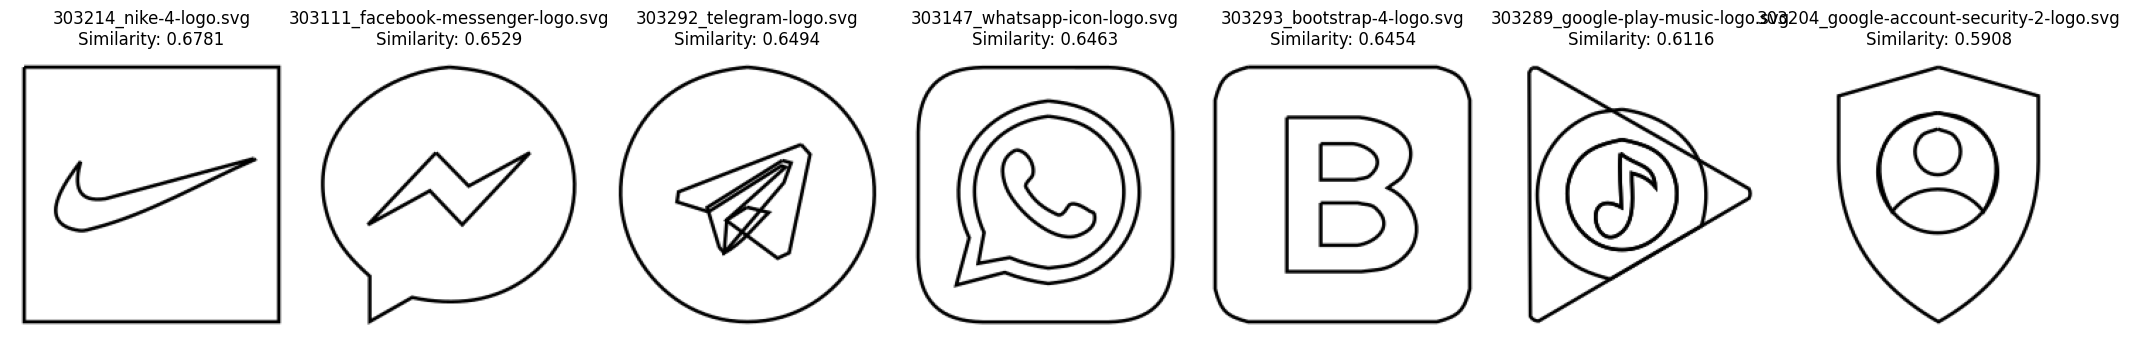

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cairosvg
from scipy.spatial.distance import cosine
from IPython.display import display
from PIL import Image

# Function to load and encode an SVG file
def load_and_encode(svg_path):
    svg = load_svg(svg_path)
    vector = encode_svg(svg)
    
    # Ensure all vectors have the same size
    if 'target_vector' in globals() and vector.shape != target_vector.shape:
        return None  # Skip inconsistent files
    
    return vector

# Function to render SVG as an image and save it in a separate folder
def render_svg(svg_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    png_filename = os.path.basename(svg_path).replace(".svg", ".png")
    png_path = os.path.join(output_dir, png_filename)
    
    # Convert SVG to PNG
    try:
        cairosvg.svg2png(file_obj=open(svg_path, "rb"), write_to=png_path)
        img = Image.open(png_path)
        return img, png_path
    except Exception as e:
        print(f"Error converting {svg_path}: {e}")
        return None, None  # Skip problematic images



# Encode the target logo
target_vector = load_and_encode(target_logo_path)
if target_vector is None:
    print("Warning: Target logo encoding failed. Check SVG format.")
else:
    # Store similarity scores
    similarities = []

    # Iterate through SVGs in data_dir
    for file in os.listdir(data_dir):
        if file.endswith(".svg"):
            file_path = os.path.join(data_dir, file)
            
            # Encode and compare
            candidate_vector = load_and_encode(file_path)
            if candidate_vector is None:
                continue  # Skip problematic files

            similarity = 1 - cosine(target_vector, candidate_vector)
            
            # Store results
            similarities.append((file, similarity, file_path))

    # Sort by similarity (highest first)
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Get the top 7 most similar logos
    top_7 = similarities[:7]

    # Display results
    print("Top 7 Most Similar Logos:")
    fig, axes = plt.subplots(1, 7, figsize=(21, 6))  # 1 row, 7 columns

    for i, (filename, score, img_path) in enumerate(top_7):
        img, saved_png_path = render_svg(img_path, png_output_dir)
        ax = axes[i]
        
        if img is not None:
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"{filename}\nSimilarity: {score:.4f}")
        else:
            ax.set_title(f"Error loading {filename}")

    plt.tight_layout()
    plt.show()
